In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

import ipywidgets as widgets

from utils import *
from basis import *
from weighting import *

Unable to import ratio-db.py, perhaps due to a missing dependency. Using fallback code.


In [2]:

pixels = (500, 500)
ratio_xy_range = ((1,4),(1,4))
fundamental_xy = (100, 100)

data = np.zeros(pixels)


x_segment = (ratio_xy_range[0][0] * fundamental_xy[0], ratio_xy_range[0][1] * fundamental_xy[0])
x_range = (x_segment[1] - x_segment[0])
y_segment = (ratio_xy_range[1][0] * fundamental_xy[1], ratio_xy_range[1][1] * fundamental_xy[1])
y_range = (y_segment[1] - y_segment[0])

weights = data.copy()
diff_weights = data.copy()

max_weight = 0
max_diff_weight = 0

# for y in range(pixels[1]):

#     y_step = float(y) / pixels[1]
#     y_freq = y_segment[0] + y_range * y_step

#     for x in range(pixels[0]):

#         x_step = float(x) / pixels[0]
#         x_freq = x_segment[0] + x_range * x_step

#         if y_freq > x_freq:
#             (d, n) = (x_freq, y_freq)
#         else:
#             (d, n) = (y_freq, x_freq)

#         ratio = n / d
#         diff = n - d

#         dyad = approximate_ratio([ratio])
#         he_weight = he_decimal_approx([ratio])

#         if diff == 0:
#             diff_weight = 1
#         else:
#             t_dyad = approximate_ratio([d / diff])

#             triad_list = np.row_stack((t_dyad, dyad))
#             triad = utils.normalize_ratios(triad_list)
#             diff_weight = he_default(triad)

#         # weight = np.sqrt(he_weight * diff_weight)

#         weights[y, x] = he_weight
#         diff_weights[y, x] = diff_weight

#         if he_weight > max_weight:
#             max_weight = he_weight
#         if diff_weight > max_diff_weight:
#             max_diff_weight = diff_weight


In [3]:
# data_he = (8 - (np.log(weights) / (np.log(2)))) / 8
# data_diff = (28 - (np.log(diff_weights)/ (np.log(2)))) / 28

# print(f"he range: {data_he.min()}, {data_he.max()}")
# print(f"diff range: {data_diff.min()}, {data_diff.max()}")

# plt.figure(figsize=(12,12))
# plt.imshow(data_he)
# # plt.imshow(data_he * data_diff)
# plt.show()

In [4]:
# continued fraction HE basis

start_harmonic = 1
end_harmonic = 2

start_cents=ratio_to_cents(start_harmonic)
end_cents=ratio_to_cents(end_harmonic)

cents_res = 1

cf_basis_cents = np.arange(start_cents, end_cents, step=cents_res)
cf_basis_length = cf_basis_cents.shape[0]

cf_basis_decimals = np.vectorize(cents_to_ratio)(cf_basis_cents)
cf_basis_cf = [ np.asarray(get_cf(d)) for d in cf_basis_decimals ]
cf_basis_ratios = np.asarray([ approximate_ratio([d])[0] for d in cf_basis_decimals ])


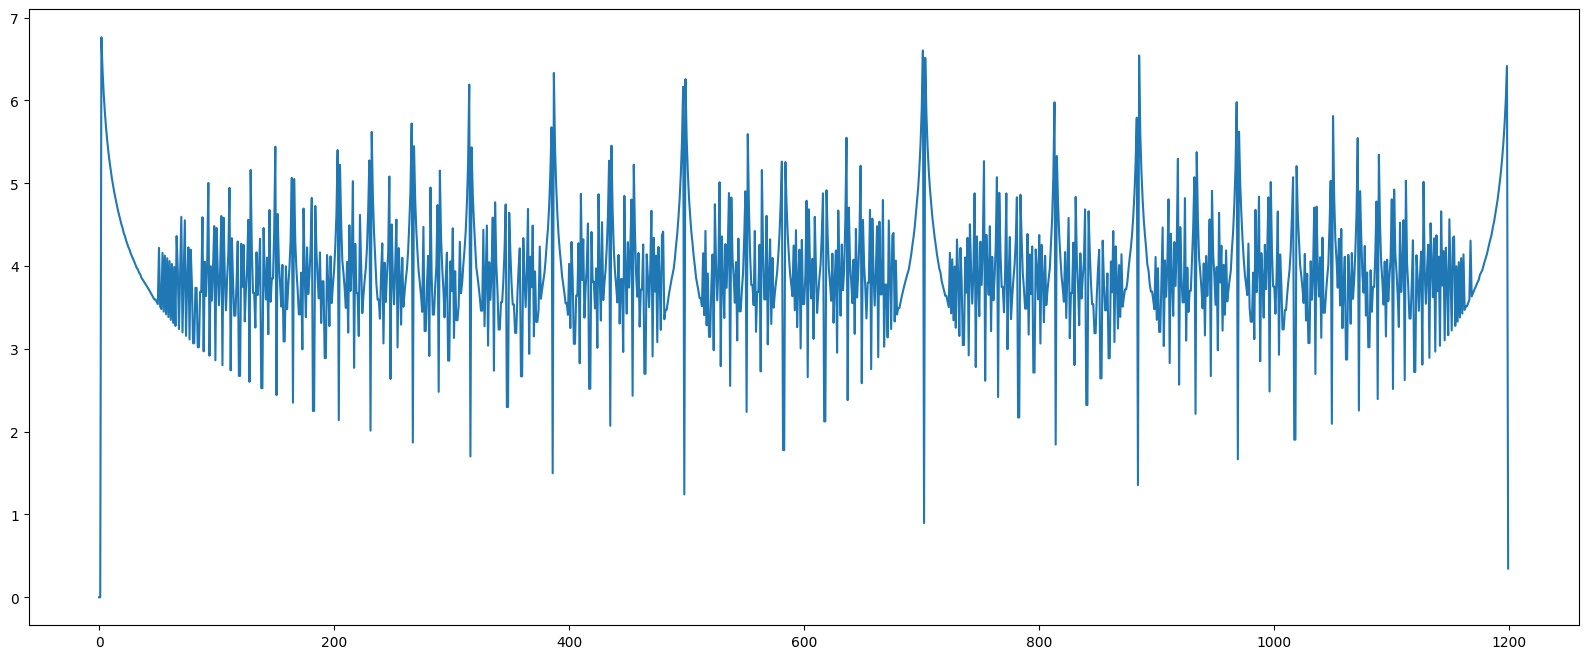

In [5]:
# do_cf_weighing = np.vectorize(he_default)
cf_basis_weights = np.apply_along_axis(he_default, 1, cf_basis_ratios)

cf_he_data = np.log(cf_basis_weights)
# cf_he_data = cf_basis_weights

plt.figure(figsize=(20,8))
plt.plot(cf_he_data)
# print()

In [6]:
scroll_default=(680,720)

scroll = widgets.FloatRangeSlider(value=scroll_default, min=0.0, max=end_cents, step=cents_res, description="CFHE scroll")
point = widgets.IntSlider(value=700, min=scroll_default[0], max=scroll_default[1], description="cents")

def get_cf_slope(cf):
    max_index = list(cf).index(cf.max())
    if max_index == 0:
        return 0

    return (cf[max_index] - cf[0]) / max_index

@widgets.interact(scroll=scroll, point=point)
def update_scroll_display(**kwArgs):
    scroll_index = kwArgs["scroll"]
    # print(scroll_index)
    # window = cf_he_data[int(round(params[0])):int(round(params[1]))]

    figure, axes = plt.subplots(2, 1)
    # plt.figure(figsize=(20,4))
    figure.set_size_inches(20, 8)

    point_x = int(kwArgs["point"])

    axes[0].plot(cf_he_data)
    axes[0].plot(point_x, cf_he_data[point_x], 'x')
    axes[0].set_xlim(scroll_index)

    cf = np.asarray(get_cf(cents_to_ratio(point_x)))
    axes[1].plot(cf)
    
    cf_range = cf.max() - cf.min()
    cf_avg = np.sum(cf) / float(cf.size)
    cf_slope = get_cf_slope(cf)

    cf_max = list(cf).index(cf.max())
    cf_axis = np.arange(cf_max+1)
    axes[1].plot(cf_axis, cf_axis * cf_slope)

    print(f'cf_range: {cf_range}')
    print(f'cf_avg: {cf_avg}')
    print(f'cf_slope: {cf_slope}')
    # for i in np.arange(int(params[0]), int(params[1])):
    #     print(f'{cf_basis_decimals[i]}:\t{cf_basis_cf[i]}')


interactive(children=(FloatRangeSlider(value=(680.0, 720.0), description='CFHE scroll', max=1200.0, step=1.0),…

In [7]:
# cf slope he

slope_window = 3600

# scroll_default=(680,720)

ctrl_scroll_x = widgets.FloatSlider(value=0, min=0.0, max=slope_window, step=cents_res, description="scroll")
ctrl_window_size = widgets.FloatSlider(value=1200, min=0.0, max=slope_window, step=cents_res, description="zoom")
ctrl_point = widgets.IntSlider(value=700, min=0, max=slope_window, description="cents")

cf_slope_weights = np.asarray([get_cf_slope(cf) for cf in cf_basis_cf[:slope_window]])
# cf_slope_rads = ((np.arctan(cf_slope_weights) * np.pi / 180.0) - np.pi / 4)**2
cf_slope_rads = (np.arctan(cf_slope_weights) * np.pi / 180.0)

# cf_slope_he_data = cf_slope_weights
# cf_slope_he_data = np.sqrt(cf_slope_weights)

cf_slope_he_data = cf_slope_weights
cf_rad_he_data = cf_slope_rads
# cf_slope_he_data = np.log(np.sqrt(cf_slope_weights))
# cf_rad_he_data = (-np.log(cf_slope_rads) * 2) ** 10

@widgets.interact(scroll=ctrl_scroll_x, window=ctrl_window_size, point=ctrl_point)
def update_scroll_display(**kwArgs):
    scroll_x = kwArgs["scroll"]
    window_size = kwArgs["window"]

    figure, axes = plt.subplots(2, 1)
    figure.set_size_inches(20, 8)

    point_x = int(kwArgs["point"])

    axes[0].plot(cf_slope_he_data)
    axes[0].plot(point_x, cf_slope_he_data[point_x], 'x')

    axes[1].plot(cf_rad_he_data)
    axes[1].plot(point_x, cf_rad_he_data[point_x], 'x')

    print(f'point {point_x}: {cf_slope_he_data[point_x]} {cf_rad_he_data[point_x]}')

    axes[0].set_xlim(scroll_x, scroll_x + window_size)
    axes[1].set_xlim(scroll_x, scroll_x + window_size)



interactive(children=(FloatSlider(value=0.0, description='scroll', max=3600.0, step=1.0), FloatSlider(value=12…

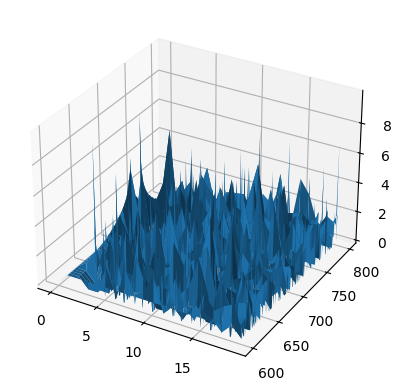

In [8]:
# cf surface

max_cf_depth = 20

cf_surf_cents_range = (600, 800)
# cf_surf_x_range = cf_surf_x_cents_range[1] - cf_surf_x_cents_range[0]
cf_surf_y_axis = np.arange(*cf_surf_cents_range)
cf_surf_num_rows = len(cf_surf_y_axis)

cf_surf_decimals = [ cents_to_ratio(c) for c in cf_surf_y_axis ]
cf_surf_cfs = [ np.asarray(get_cf(d, max_cf_depth)) for d in cf_surf_decimals ]

X = np.arange(max_cf_depth)
# Y = np.arange(cf_surf_num_rows)
Z = np.zeros((cf_surf_num_rows, max_cf_depth))

for i in range(cf_surf_num_rows):
    cf = cf_surf_cfs[i]
    l = len(cf)
    Z[i, :l] += cf

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

Xm,Ym = np.meshgrid(X, cf_surf_y_axis)
ax.plot_surface(Xm, Ym, np.log(Z))


Preparing basis...
Weighting...
Transforming basis...
Convolving...
weigh2: 0.08661175651120001
weigh2: nan


C:\Windows\Temp\ipykernel_26908\82050293.py:52: RuntimeWarning: divide by zero encountered in log2
  return -(pl)*np.log2(pl) - (pr)*np.log2(pr)
C:\Windows\Temp\ipykernel_26908\82050293.py:52: RuntimeWarning: invalid value encountered in scalar multiply
  return -(pl)*np.log2(pl) - (pr)*np.log2(pr)


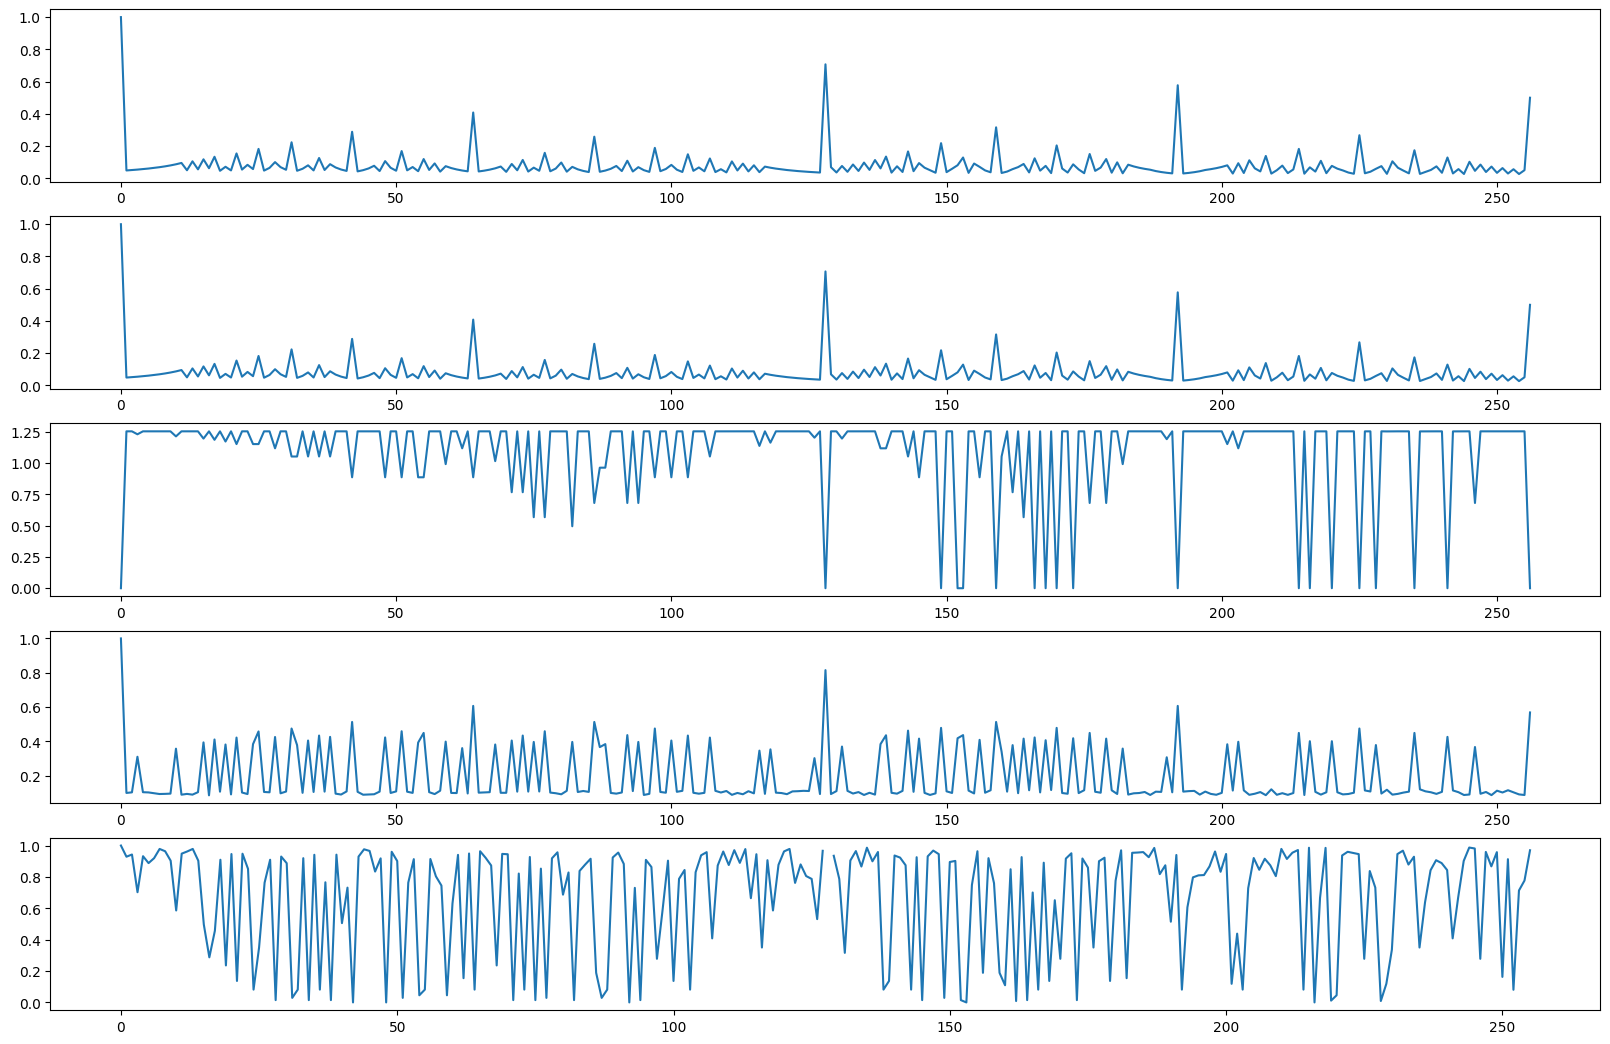

In [9]:
# compare he weights to cf weights

import he 

harmonicEntropy = he.HarmonicEntropy(N=20)
harmonicEntropy.calculate()

he_basis_decimals = np.vectorize(cents_to_ratio)(harmonicEntropy.basis_cents)
he_basis_cfs =  [ get_cf(d, 64) for d in he_basis_decimals ]
he_basis_cf_weights = 1 / np.vectorize(lambda d: he_decimal_approx([d], 1024, 0.1))(he_basis_decimals)
he_basis_slopes = [ np.sqrt(np.arctan(get_cf_slope(np.asarray(cf)))) for cf in he_basis_cfs ]

def get_cf_weight2(cf):
    # we want to make a number that's bigger for how dissonant it is
    # unsure of scaling/range but max consonance could either be 0 or 1 depending on space

    # if a cf is shorter than max length it's basically rational
    # for values very close to a rational number things can get funky so use error to find weight based on ideal weight
    # firmly irrational numbers will not have a large variation in cf digit magnitudes
    
    
    # idea -- combine different measures
    # rational index - how close it is to a rational number, used to factor error in
    # harmonic index - how harmonic the rationals are
    
    # irrational index - how close it is to a irrational sequence (maybe determine some other harmonic measure)
    # like the golden ratio can we see if it has good combination tone properties?
    # or inspired from the square root of two could we have some measures of maximal dissonance (versus maximal consonance like unison)

    # look at CFs of ratio log2s?? or log3s??? etc. (approximate closeness to an equal temperament interval...probably not useful.)
    #   -- maybe in context of chords looking at a square root of some intervals could be useful for arithmetic indexes

    # hypsum test
    return (1 - (1 - 0.5 / np.log2(np.sum(np.vectorize(lambda x: np.sqrt(1+x*x))(np.asarray(cf))))) ** 3)

def get_cf_entropy(cf, max_bits=None):
    if max_bits is None:
        max_bits = len(cf)
    bits = [ 0, 0 ]
    k = 0 if cf[0] > 0 else 1
    i = 0 if cf[0] > 0 else 1
    while i < len(cf) and i <= max_bits:
        bits[k] += cf[i]
        i+=1
        k = (k+1)%2
    amt = bits[0]+bits[1]
    if amt == 1:
        return 0
    
    pl = bits[0]/amt
    pr = bits[1]/amt
    return -(pl)*np.log2(pl) - (pr)*np.log2(pr)
def get_cf_entropy_dec(dec, max_bits=64):
    return get_cf_entropy(get_cf(dec, max_bits, 1e7), max_bits)

he_basis_weights2 = np.asarray([ get_cf_weight2(cf) for cf in he_basis_cfs ])
print(f"weigh2: {he_basis_weights2.min()}")

he_basis_weights3 = np.asarray([ 1 - get_cf_entropy(cf) for cf in he_basis_cfs ])
print(f"weigh2: {he_basis_weights3.min()}")


figure, axes = plt.subplots(5, 1)
figure.set_size_inches(20, 13)

axes[0].plot(harmonicEntropy.basis_weights)
axes[1].plot(he_basis_cf_weights)
axes[2].plot(he_basis_slopes)
axes[3].plot(he_basis_weights2)
axes[4].plot(he_basis_weights3)

In [10]:
# Turn CF approximation errors into an IR

gr = 2 / (1 + np.sqrt(5))

ctrl_num = widgets.FloatSlider(value=gr, min=1e-6, max=1, step=1e-6, description="number")
ctrl_max_length = widgets.IntSlider(value=10, min=1, max=25, step=1, description="length")
# ctrl_invert = widgets.Checkbox(value=False, description="invert")
ctrl_exp = widgets.FloatSlider(value=1, min=-3, max=3, step=1e-2)

@widgets.interact(num=ctrl_num, length=ctrl_max_length, exp=ctrl_exp)
def update_scroll_display(**kwArgs):

    figure, axes = plt.subplots(2, 1)

    num = kwArgs["num"]
    length = kwArgs["length"]
    # invert = kwArgs["invert"]
    # sign = -1 if invert else 1

    exp = kwArgs["exp"]

    cf = get_cf(num, length)

    convergents = [ get_convergent(cf, i) for i in range(1, length + 1) ]
    approximations = [ (approx[0] / approx[1]) for approx in convergents ]
    # print(approximations)

    ir_data = [ ((a - num))**exp for a in approximations  ]

    # axes[0].figure(1)
    axes[0].plot(ir_data)

    w, h = signal.freqz(ir_data, worN=8000)
    axes[1].plot((w/np.pi)*0.5, np.abs(h), linewidth=2)



interactive(children=(FloatSlider(value=0.6180339887498948, description='number', max=1.0, min=1e-06, step=1e-…